In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as integ


import matplotlib.pyplot as plt
import time



# Ejecuta esta celda para introducir los datos
datostld100 = 'datos/datostld100.xlsx'
DatosEntrada = pd.read_excel(
    datostld100, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

dfnew = DatosEntrada


def leer_datos(dfnew):

    E = dfnew.iloc[:, 0].to_numpy()         # Energia de Activación (eV).
    s = dfnew.iloc[:, 1].to_numpy()          # Factor de Frecuencia (s-1).
    # Concentracion de electrones atrapados en las trampas (cm-3).
    n = dfnew.iloc[:, 2].to_numpy()
    # Numero de posiciones acesibles por los electrnes de la BC a la Trampa (cm-3).
    N = dfnew.iloc[:, 3].to_numpy()
    # Numero de posiciones acesibles por los electrones alcanzada la saturación (cm-3).
    Nsat = dfnew.iloc[:, 4].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de electrones de a trampa (cm+3·s-1).
    A = dfnew.iloc[:, 5].to_numpy()
    # Coeficiente de probabilidad de recombinacion e-h Radiativa (cm+3·s-1).
    Amn_R = dfnew.iloc[0:1, 6].to_numpy()
    # Coeficiente de probabilidad de recombinacion e-h No Radiativa (cm+3·s-1).
    Amn_NR = dfnew.iloc[0:1, 7].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion Radiativo (cm+3·s-1).
    A_R = dfnew.iloc[0:1, 8].to_numpy()
    # Coeficiente de Probabilidad de atrapamiento de huecos de la BV al Centro de Recombinacion No Radiativo (cm+3·s-1).
    A_NR = dfnew.iloc[0:1, 9].to_numpy()
    # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion Radiativo (cm-3).
    M_R = dfnew.iloc[0:1, 10].to_numpy()
    # Numero de posiciones acesibles huecos de la BV al Centro de Recombinacion No Radiativo (cm-3).
    M_NR = dfnew.iloc[0:1, 11].to_numpy()
    # Concentracion de h atrapados en el centro de recombonacion radiativo (cm-3).
    m_R = dfnew.iloc[0:1, 12].to_numpy()
    # Concentracion de h atrapados en el centro de recombonacion no radiativo (cm-3).
    M_NR = dfnew.iloc[0:1, 13].to_numpy()
    # Factor de generacion de pares e-h (cm-3·s-1).
    f = dfnew.iloc[0:1, 14].to_numpy()
    # Concentración de electrones libres en la banda de conduccion (cm-3).
    n_c = dfnew.iloc[0:1, 15].to_numpy()
    # Concentración de huecos libres en la banda de Valencia (cm-3).
    n_h = dfnew.iloc[0:1, 16].to_numpy()
    # Nivel de Fermi (Ev)
    Ef = dfnew.iloc[0:1, 17]
    Ef = float(Ef)

    return E, s, n, N, Nsat, A, Amn_R, Amn_NR, A_R, A_NR, M_R, m_R, M_NR, f, n_c, n_h, Ef


# Condiciones iniciales

E, s, n, N, Nsat, A, Amn_R, Amn_NR, A_R, A_NR, M_R, m_R, M_NR, f, n_c, n_h, Ef = leer_datos(
    dfnew)


nn = np.array(n_c[0])
for i in range(len(n)):
    nn = np.append(nn, n[i])
nn = np.append(nn, m_R[0])
nn = np.append(nn, M_NR[0])
nn = np.append(nn, n_h[0])

# Constante de boltzman
kb = 0.00008617333262
kb = 8.617333262E-5

# Ejecuta esta celda para definir las funciones del modelo

# aquí definimos el N de saturación y corregimos el numero de trampas en 4 a parte de definir las funciones de N
# aquí definimos el N de saturación y corregimos el numero de trampas en 4 a parte de definir las funciones de N
Nsat = np.ones(len(N))*10**11
# N[3]=N[3]/2
# N[4]=3*N[4]/4
if len(N) == 5:
    Nsat[0] = Nsat[0]*25
    Nsat[1] = Nsat[1]*10
    Nsat[2] = Nsat[2]*5
    Nsat[3] = Nsat[3]*5
    Nsat[4] = Nsat[4]*65


def Ng(t, i):  # En esta función simulamos la creación de trampas durante la irradiación
    C = 1
    return N[i] * np.exp(np.log10(Nsat[i] / N[i]) * (1 - np.exp(-C * t)))


def Nee(E, i, T):  # Esta es la distribución de Fermi-Dirac que utilizaremos en la irradiación
    return N[i] / (1 + np.exp((E - Ef) / (kb * T)))


def NFCT(E, i, T, t):  # Aquí simulamos la creación de trampas durante la irradiación, utilizando también la distribución de Fermi-Dirac
    return Nee(E, i, T) * Ng(t, i) / N[i]


NN = N


def Ne(E, i, T):  # Aquí definimos la distribución de Fermi-Dirac
    # para utilizarla utilizando el numero de trampas disponibles tras la irradiación
    return NN[i] / (1 + np.exp((E - 2.7) / (kb * T)))


Tamb = 273.15


def TLIN(t, u):  # Con esta función simulamos la irradiación añadiendo la creación de trampas,
    # utilizando la función de arrenius para la probabilidad
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (Ng(t, i - 1) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLINE(t, u):  # Aquí simulamos la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))) + \
            A[i - 1] * (NFCT(E[i - 1], i - 1, Tamb, t) - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f - Constante_A - u[0] * (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f - u[-1] * (+A_R[0] * (M_R[0] - u[-3]) +
                          A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLRNE(t, u):  # Simulamos la relajación tras la irradiación (reduciendo la fuente de radiación en un factor 1000) partiendo de las concentraciones y
    # el número de trampas tras la irradiación añadiendo la creación de trampas, utilizando la distribución de F-D  Nota: revisar que esté bien implementado
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                         ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
        Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def TLI(t, u):  # Simulación de la irradiación sin tener en cuenta la creación de trampas usando la ley de arrenius
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLR(t, u):  # Simulación de la relajación de la función anterior
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))) + \
            A[i-1]*(N[i-1]-u[i])*u[0]
        Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def TLE(t, u):  # Simulación del calentamiento
    Tamb = 297.15 + float(t) * beta
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx) - 3):
        if u[i] > 10:
            dx[i] = -u[i] * (s[i - 1] * np.exp(-E[i - 1] / (kb * Tamb))
                             ) + A[i - 1] * (NN[i - 1] - u[i]) * u[0]
            Constante_A += dx[i]
    dx[0] = f / 1000 - Constante_A - u[0] * \
        (u[-3] * Amn_R[0] + u[-2] * Amn_NR[0])
    dx[-3] = A_R[0] * (M_R[0] - u[-3]) * u[-1] - u[0] * (u[-3] * Amn_R[0])
    dx[-2] = A_NR[0] * (M_NR[0] - u[-2]) * u[-1] - u[0] * (u[-2] * Amn_NR[0])
    dx[-1] = f / 1000 - u[-1] * \
        (+A_R[0] * (M_R[0] - u[-3]) + A_NR[0] * (M_NR[0] - u[-2]))
    return np.array(dx, dtype=object)


def CT(t):
    return 297.15 + float(t) * 10


def TLECT(t, u):  # Simulación del calentamiento utilizando una curva de temperaturas
    # a elección (CT(t))
    Tamb = CT(t)
    kb = 0.00008617333262
    dx = np.zeros(len(nn))
    Constante_A = 0.0
    for i in range(1, len(dx)-3):
        if u[i] > 10:
            dx[i] = -u[i]*(s[i-1]*np.exp(-E[i-1]/(kb*Tamb))
                           )+A[i-1]*(NN[i-1]-u[i])*u[0]
            Constante_A += dx[i]
    dx[0] = f/1000-Constante_A-u[0]*(u[-3]*Amn_R[0]+u[-2]*Amn_NR[0])
    dx[-3] = A_R[0]*(M_R[0]-u[-3])*u[-1]-u[0]*(u[-3]*Amn_R[0])
    dx[-2] = A_NR[0]*(M_NR[0]-u[-2])*u[-1]-u[0]*(u[-2]*Amn_NR[0])
    dx[-1] = f/1000-u[-1]*(+A_R[0]*(M_R[0]-u[-3])+A_NR[0]*(M_NR[0]-u[-2]))
    return np.array(dx, dtype=object)


def tl(X, T, beta):  # Calculamos la curva de termoluminiscencia
    Temp = np.zeros(len(T))
    TL = np.zeros(len(T))
    for i in range(len(T)):
        Temp[i] = T[i]*beta+297.15-273.15
        TL[i] = A_R*X[0, i]*X[-3, i]/beta
    return Temp, TL


def tl200(X, T, beta):  # Guardamos 200 canales de la curva de termoluminiscencia
    Temp, TL = tl(X, T, beta)
    ti200 = np.linspace(T[0], T[-1], 200)
    t200 = np.linspace(Temp[0], Temp[-1], 200)
    tl200 = np.interp(t200, Temp, TL)
    return t200, tl200, ti200


def g200(X, T):
    x = np.zeros((200, len(X[0])), dtype=X.dtype)
    t = np.linspace(T[0], T[-1], 200)
    for i in range(len(X[1])):
        x[:, i] = np.interp(t, T, X[:, i])
    return (x, t)


# Iniziamos la variable que albergará el nuevo número de trampas
NN = np.zeros(len(N))


In [2]:
dfnew.head()

,E (eV),s (s-1),n(cm-3),Nn(cm-3),Nsat(cm-3),A(cm+3·s-1),RAmn(cm+3·s-1),NRAmn(cm+3·s-1),RAh(cm+3·s-1),NRAh(cm+3·s-1),RM(cm-3),NRM(cm-3),Rm(cm-3),NRm(cm-3),f(cm-3·s-1),nc(cm-3),nvcm-3),Ef
0,1.708133,5.298385e+20,0,10000000000,25000000000000,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-11,1.000000e-11,1.000000e+09,1.000000e+09,0.0,0.0,10000000.0,0.0,0.0,2.7
1,1.565926,3.200997e+17,0,10000000000,10000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.642103,2.709883e+17,0,10000000000,5000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.129357,4.537204e+21,0,10000000000,5000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.500000,1.000000e+12,0,10000000000,65000000000000,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(dfnew['E (eV)'] / 2.7)

0    0.632642
1    0.579973
2    0.608186
3    0.788651
4    0.925926
Name: E (eV), dtype: float64


In [2]:
import scienceplots

plt.style.use('science')

In [5]:
# Irradiación y relajación:
tmax = 20
tmaxr = 20
pasos = 100
# tmax=20                 #tiempo de irradiación
solirad = integ.RK45(fun=TLINE, t0=0, y0=nn, t_bound=tmax, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)

for i in range(len(N)):
    # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
    NN[i] = NFCT(E[i], i, 297.15, tmax)
ti = []
xi = []  # Iniziamos la variable que

for i in range(100):

    for i in range(1000):
        # get solution step state
        if solirad.status == 'finished':
            break
        solirad.step()
        ti.append(solirad.t)
        xi.append(solirad.y)
        # break loop after modeling is finished
        if solirad.status == 'finished':
            break
    xtemp, ttemp = g200(np.array(xi), ti)
print('Irradiación finalizada')

solrel = integ.RK45(fun=TLRNE, t0=0, y0=xi[-1], t_bound=tmaxr, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tr = []
xr = []  # Iniziamos la variable que

for i in range(pasos):
    for i in range(1000):
        if solrel.status == 'finished':
            break
        # get solution step state
        solrel.step()
        tr.append(solrel.t)
        xr.append(solrel.y)
        # break loop after modeling is finished
        if solrel.status == 'finished':
            break
    xtempr = np.array(xr)

    # Representamos la concentración en las trampas en la relajación
xi = np.array(xi)
xr = np.array(xr)

Irradiación finalizada


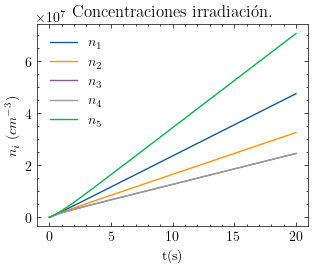

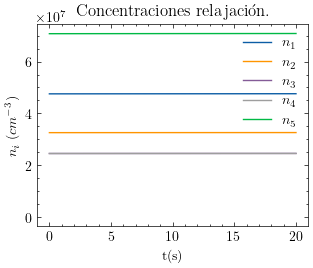

In [6]:
# Representamos la concentración en las trampas en la irradiación
for i in range(1, len(nn)-3):
    plt.plot(ti, xi[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones irradiación.')
    plt.xlabel('t(s)')
    plt.ylabel(r'$n_i$ ($cm^{-3}$)')
plt.show()


for i in range(1, len(nn)-3):
    plt.plot(tr, xr[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones relajación.')
    plt.xlabel('t(s)')
    plt.ylabel(r'$n_i$ ($cm^{-3}$)')
plt.show()

In [8]:
# calentamiento
for i in range(len(N)):
    # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
    NN[i] = NFCT(E[i], i, 297.15, 230+273.15)

CC = xr[-1]

beta = 10
# aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
mt = ((230+273.15)-Tamb)/beta

solcal = integ.RK45(fun=TLE, t0=0, y0=CC, t_bound=mt, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tc = []
xc = []  # Iniziamos la variable que
TT = []

for j in range(100):
    for i in range(3000):
        # get solution step state
        if solcal.status == 'finished':
            break
        solcal.step()
        tc.append(solcal.t)
        TT.append(solcal.t*beta+Tamb-273.15)
        xc.append(solcal.y)
        # break loop after modeling is finished
        if solcal.status == 'finished':
            break
xtemp = np.array(xc)
ttemp = np.array(tc)
xg, tg = g200(xtemp, TT)
# Representamos la concentración en las trampas en la relajación
temp, tlc, ti200 = tl200(xtemp.T, tc, beta)
print('Calentamiento finalizado')

Calentamiento finalizado


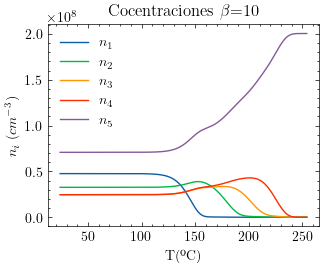

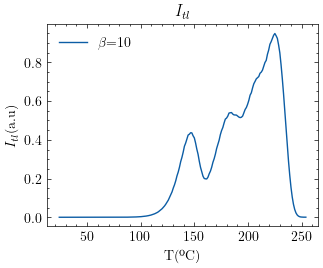

In [9]:

for i in range(1, len(nn)-3):
    plt.plot(temp, xg[:, i], label=f'$n_{i}$')
plt.legend()

plt.title(r'Cocentraciones $\beta$=' + str(beta))
plt.xlabel('T(ºC)')
plt.ylabel(r'$n_i$ ($cm^{-3}$)')
plt.show()

# plt.plot(ttemp/mt*200,tlc)
plt.plot(temp, tlc ,label=r'$\beta$='+str(beta))
plt.legend()

plt.title(r'$I_{tl}$')
plt.xlabel('T(ºC)')
plt.ylabel(r'$I_{tl}$(a.u)')
plt.show()

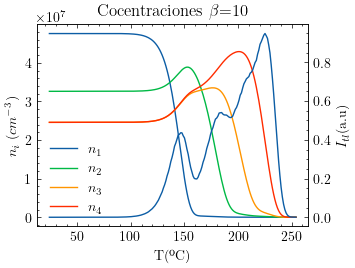

In [34]:
fig, ax1 = plt.subplots()

# Primera gráfica con eje y principal
for i in range(1, len(nn)-4):
    ax1.plot(temp, xg[:, i], label=f'$n_{i}$')
ax1.set_xlabel('T(ºC)')
ax1.set_ylabel(r'$n_i$ ($cm^{-3}$)')
ax1.set_title(r'Cocentraciones $\beta$=' + str(beta))
ax1.legend()

# Segunda gráfica con eje y secundario
ax2 = ax1.twinx()
ax2.plot(temp, tlc, label=r'$I_{tl}$(a.u)')
ax2.set_ylabel(r'$I_{tl}$(a.u)')
#ax2.legend()

plt.show()

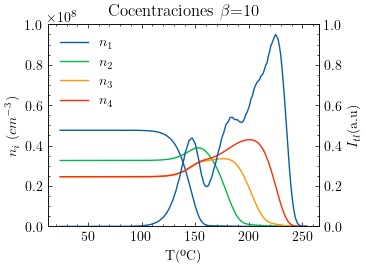

In [42]:
fig, ax1 = plt.subplots()

# Primera gráfica con eje y principal
for i in range(1, len(nn)-4):
    ax1.plot(temp, xg[:, i], label=f'$n_{i}$')
ax1.set_xlabel('T(ºC)')
ax1.set_ylabel(r'$n_i$ ($cm^{-3}$)')
ax1.set_title(r'Cocentraciones $\beta$=' + str(beta))
ax1.legend(loc='upper left')

# Segunda gráfica con eje y secundario
ax2 = ax1.twinx()
ax2.plot(temp, tlc, label=r'$I_{tl}$(a.u)')
ax2.set_ylabel(r'$I_{tl}$(a.u)')
#ax2.legend()

# Personalizar las escalas de los ejes
#ax1.set_xlim([xmin, xmax])  # Establece los límites del eje x
ax1.set_ylim([0, 10E+7])  # Establece los límites del eje y principal
ax2.set_ylim([0, 1])  # Establece los límites del eje y secundario

plt.show()


In [215]:
((230+273.15)-Tamb)

230.0

In [216]:
TTTT = np.linspace(0,230,500)

In [14]:
from scipy.integrate import solve_ivp
# Vamos a simular para 5 valores de beta:
betas = [2, 4, 6, 8, 10]  # Lista de valores de beta
CC = xr[-1]
# Vectores para almacenar los resultados
X2 = []
X4 = []
X6 = []
X8 = []
X10 = []

for beta in betas:
    # Código para la resolución del sistema para cada valor de beta
    # ... (resto de tu código aquí) ...
    mt = ((230+273.15)-Tamb)/beta
    t = np.linspace(0,mt,200)
    solcal = solve_ivp(fun=TLE, t_span=(0, mt),t_eval=t, y0=CC, method='RK45',
                       rtol=0.01, atol=0.0001, vectorized=False)

    # Guardar los resultados en los vectores correspondientes
    if beta == 2:
        X2.append(solcal.y)
    elif beta == 4:
        X4.append(solcal.y)
    elif beta == 6:
        X6.append(solcal.y)
    elif beta == 8:
        X8.append(solcal.y)
    elif beta == 10:
        X10.append(solcal.y)

# Convertir los resultados en arrays numpy si es necesario
X2 = np.array(X2)
X4 = np.array(X4)
X6 = np.array(X6)
X8 = np.array(X8)
X10 = np.array(X10)

print('\u0007')




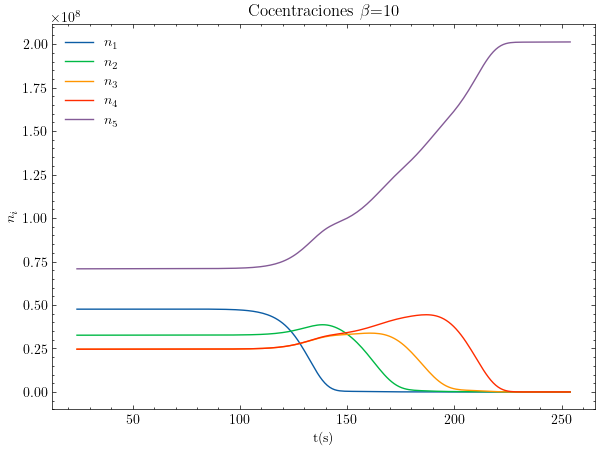

(1, 9, 200)

In [16]:
data = [X2, X4, X6, X8, X10]
tg = np.linspace(0,200,500)
xg = X2.T
fig = plt.figure(figsize=(7,5))
for i in range(1, len(nn)-3):
    plt.plot(temp, xg[:, i], label=f'$n_{i}$')
plt.legend()

plt.title(r'Cocentraciones $\beta$=' + str(beta))
plt.xlabel('t(s)')
plt.ylabel('$n_i$')
plt.show()

X2.shape

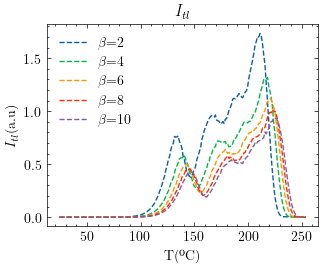

In [21]:

[2, 4, 6, 8, 10]
for X, b in zip([X2, X4, X6, X8, X10],[2, 4, 6, 8, 10]):
    xg = X.T
    tlc = np.zeros(200)
    for i in range(200):
        tlc[i] = A_R*xg[i,0]*xg[i,-3] /b
    plt.plot(temp, tlc,'--' ,label=r'$\beta$='+str(b))


plt.legend()

plt.title(r'$I_{tl}$')
plt.ylabel(r'$I_{tl}$(a.u)')
plt.xlabel('T(ºC)')
plt.show()

In [24]:
[2, 4, 6, 8, 10]
MAXS = []
MAX_VALS = []
for X, b in zip([X2, X4, X6, X8, X10],[2, 4, 6, 8, 10]):
    xg = X.T
    # Cálculo de tlc
    tlc = np.zeros(200)
    for i in range(200):
        tlc[i] = A_R * xg[i, 0] * xg[i, -3] / b

    # Encontrar los índices de los máximos relativos (picos)
    peaks_indices = argrelextrema(tlc, np.greater, order=5)[0]
    peaks_values = tlc[peaks_indices]
    MAXS.append(peaks_indices)
    MAX_VALS.append(peaks_values)
    plt.plot(TTTT[peaks_indices], peaks_values,'.', label=f'$\\beta$={b}')
plt.legend()
plt.show()

NameError: name 'argrelextrema' is not defined

[  4  48  69 237 304 310 358 403 475 484 498]
[0.   0.   0.   0.78 0.95 0.96 1.15 1.78 0.   0.   0.  ]
[237 304 310 358 403 475 484 498]
[0.78 0.95 0.96 1.15 1.78 0.   0.   0.  ]
[237 310 358 403]
[0.77841368 0.96411648 1.15040509 1.78084795]


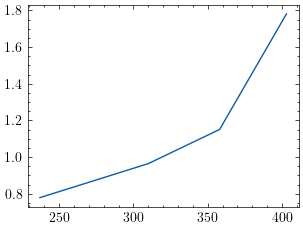

In [183]:
print(MAXS[0])
print(np.round(MAX_VALS[0],2))
m_2 = MAXS[0]
v_2 = MAX_VALS[0]
m_2 = m_2[3:]
v_2 = v_2[3:]
print(m_2)
print(np.round(v_2,2))
m_2 = m_2[[0,2,3,4]]
print(m_2)
v_2 = v_2[[0,2,3,4]]
print(v_2)
plt.plot(m_2, v_2)
plt.show()

In [236]:
TTTT[403]

185.75150300601203

In [182]:
print(MAXS[1])
print(np.round(MAX_VALS[1],2))
m_4 = MAXS[1]
v_4 = MAX_VALS[1]
m_4 = m_4[2:]
v_4 = v_4[2:]
print(m_4)
print(np.round(v_4,2))
m_4 = m_4[[0,2,5,6]]
print(m_4)
v_4 = v_4[[0,2,5,6]]
print(v_4)

[  8  51 248 319 327 335 343 387 420 485 493]
[0.   0.   0.59 0.72 0.73 0.72 0.7  0.95 1.33 0.   0.  ]
[248 319 327 335 343 387 420 485 493]
[0.59 0.72 0.73 0.72 0.7  0.95 1.33 0.   0.  ]
[248 327 387 420]
[0.59042913 0.72945185 0.9523388  1.32874388]


In [181]:
print(MAXS[2])
print(np.round(MAX_VALS[2],2))
m_6 = MAXS[2]
v_6 = MAX_VALS[2]
m_6 = m_6[4:8]
v_6 = v_6[4:8]
print(m_6)
print(np.round(v_6,2))


[  6  19  25  31 257 336 388 427 491]
[0.   0.   0.   0.   0.51 0.63 0.82 1.12 0.  ]
[257 336 388 427]
[0.51 0.63 0.82 1.12]


In [195]:
print(MAXS[3])
print(np.round(MAX_VALS[3],2))
m_8 = MAXS[3]
v_8 = MAX_VALS[3]
m_8 = m_8[3:]
v_8 = v_8[3:]
print(m_8)
print(np.round(v_8,2))
m_8 = m_8[[0,2,3]]
print(m_8)
v_8 = v_8[[0,2,3]]
print(v_8)

[  1   8  17 264 337 344 432]
[0.   0.   0.   0.45 0.57 0.58 1.01]
[264 337 344 432]
[0.45 0.57 0.58 1.01]
[264 344 432]
[0.4546906  0.5768189  1.01477152]


In [194]:
print(MAXS[4])
print(np.round(MAX_VALS[4],2))
m_10 = MAXS[4]
v_10 = MAX_VALS[4]
m_10 = m_10[3:]
v_10 = v_10[3:]
print(m_10)
print(np.round(v_8,2))
m_10 = m_10[[0,1,3]]
print(m_10)
v_10 = v_10[[0,1,3]]
print(v_10)

[  2  12  23 268 345 365 434]
[0.   0.   0.   0.43 0.54 0.52 0.95]
[268 345 365 434]
[0.45 0.58 1.01]
[268 345 434]
[0.43460723 0.53975757 0.94785383]


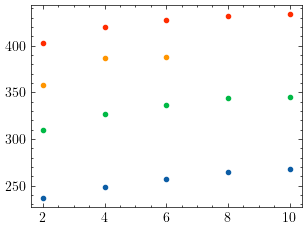

In [217]:
pico1 = [m_2[0], m_4[0], m_6[0], m_8[0], m_10[0]]
TM1 = TTTT[pico1]
pico2 = [m_2[1], m_4[1], m_6[1], m_8[1], m_10[1]]
TM2 = TTTT[pico2]
pico3 = [m_2[2], m_4[2], m_6[2]]
TM3 = TTTT[pico3]
pico4 = [m_2[3], m_4[3], m_6[3], m_8[2], m_10[2]]
TM4 = TTTT[pico4]
plt.plot(betas, pico1, '.')
plt.plot(betas, pico2, '.')
plt.plot(betas[:3], pico3, '.')
plt.plot(betas, pico4, '.')

plt.show()

In [238]:
print(TM4)

[185.75150301 193.58717435 196.81362725 199.11823647 200.04008016]


In [249]:
#k = 0.00008617333262
k=1
XX1 = k*1/TM1
XX2 = k*1/TM2
XX4 = k*1/TM4

YY1 = np.log(TM1**2/betas[0])
YY2 = np.log(TM1**2/betas[1])
YY4 = np.log(TM4**2/betas[3])

EKIZ = [XX1,XX2,XX4]

m1 -232.12989132673022
m2 -334.4245658602152
m3 -385.1026251567588


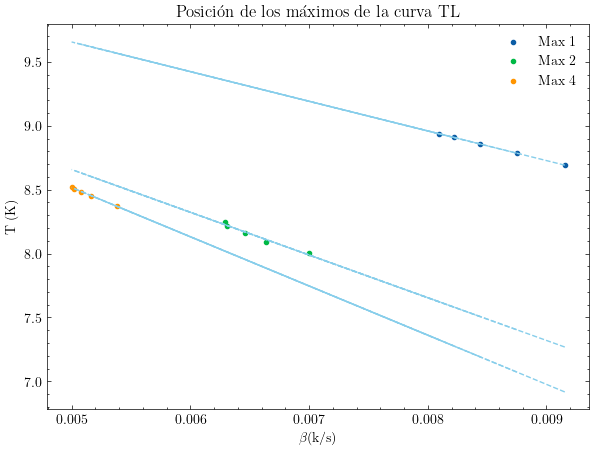

In [250]:
# Ajuste de una regresión lineal y trazado de la línea resultante para cada pico
plt.figure(figsize=(7,5))

plt.plot(XX1, YY1, '.', label='Max 1')
slope, intercept = np.polyfit(XX1, YY1, 1)
plt.plot(EKIZ, slope * np.array(EKIZ) + intercept,'--', color='skyblue')
print('m1',slope)
plt.plot(XX2, YY2, '.', label='Max 2')
slope, intercept = np.polyfit(XX2, YY2, 1)
plt.plot(EKIZ, slope * np.array(EKIZ) + intercept,'--', color='skyblue')
print('m2',slope)
# plt.plot(betas[:3], pico3, '.', label='Pico 3')
# slope, intercept = np.polyfit(betas[:3], pico3, 1)
# plt.plot(betas[:3], slope * np.array(betas[:3]) + intercept,'--', color='skyblue')

plt.plot(XX4, YY4, '.', label='Max 4')
slope, intercept = np.polyfit(XX4, YY4, 1)
plt.plot(EKIZ, slope * np.array(EKIZ) + intercept,'--', color='skyblue')
print('m3',slope)
plt.legend()
plt.xlabel('$\\beta$(k/s)')
plt.ylabel('T (K)')
plt.title('Posición de los máximos de la curva TL')
plt.show()

In [245]:
print(pico1)

[237, 248, 257, 264, 268]


In [248]:
dfg = pd.DataFrame([pico1, pico2, pico3,pico4], columns = ['pico1', 'pico2', 'pico3', 'pico4',''])
dfg.to_csv('picos.csv')

In [28]:
dfg = pd.read_csv('picos.csv')

In [40]:
dfg.head()

,Unnamed: 0,pico1,pico2,pico3,pico4,Unnamed: 5
0,0,237,248,257,264.0,268.0
1,1,310,327,336,344.0,345.0
2,2,358,387,388,NaN,NaN
3,3,403,420,427,432.0,434.0


In [176]:
print(temp[-1])

254.0


In [184]:
print(283/500*np.array(dfg.iloc[0,1:]))

[134.142 140.368 145.462 149.424 151.688]


In [22]:
tpico = np.array(283/500*dfg.iloc[0,1:])+273.15
k = 0.00008617333262
plt.plot(1/(tpico), np.log(tpico**2/betas), '.')
slope, intercept = np.polyfit(1/tpico,np.log(tpico**2/betas),1)
plt.plot(1/tpico, slope * 1/tpico + intercept,'--', color='skyblue', label=f'$E_1$={np.round(k*slope,4)}')
plt.legend()
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')
plt.show()


print(slope)

NameError: name 'dfg' is not defined

In [3]:
betas = [2,4,6,8,10]

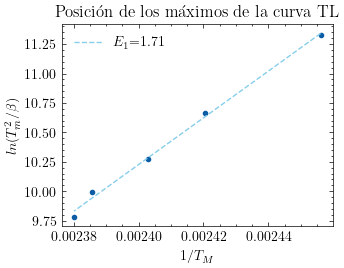

In [4]:
k = 0.0008617333262
k = 8.617333262E-5
tes = np.array([134,140,143,146,147])+273.15
plt.plot(1/(tes), np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes,np.log(tes**2/betas),1)
plt.plot(1/tes, slope * 1/tes + intercept,'--', color='skyblue', label=f'$E_1$={np.round(k*slope,2)}')
plt.legend()
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


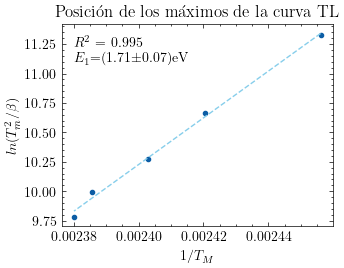

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
k = 8.617333262E-5
tes = np.array([134, 140, 143, 146, 147]) + 273.15


# Gráfica
plt.plot(1/tes, np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes, np.log(tes**2/betas), 1)
plt.plot(1/tes, slope * 1/tes + intercept, '--', color='skyblue')

# Coeficiente de determinación (R^2)
residuals = np.log(tes**2/betas) - (slope * 1/tes + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(tes**2/betas) - np.mean(np.log(tes**2/betas)))**2)
r_squared = 1 - (ss_res / ss_tot)

# Agregar R^2 a la leyenda
plt.legend(title=f'$R^2$ = {np.round(r_squared, 3)}\n $E_1$=({np.round(k*slope,2)}$\pm$0.07)eV')

# Configuración de ejes y título
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')

# Mostrar gráfica
plt.show()


In [24]:
import numpy as np

# Datos
x = 1/tes
y = np.log(tes**2/betas)

# Cálculo de la pendiente y la intersección
slope, intercept = np.polyfit(x, y, 1)

# Cálculo del error en la pendiente
residuals = y - (slope * x + intercept)
ss_res = np.sum(residuals**2)
ss_x = np.sum((x - np.mean(x))**2)
std_error = np.sqrt(ss_res / (len(x) - 2))
error_pendiente = std_error / np.sqrt(ss_x)

print("Error en la pendiente:", error_pendiente)
print(slope*k, k*error_pendiente)


Error en la pendiente: 781.9474540878125
1.7112950704840864 0.06738301805247125


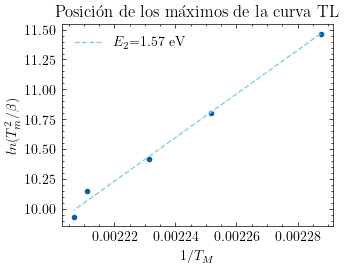

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


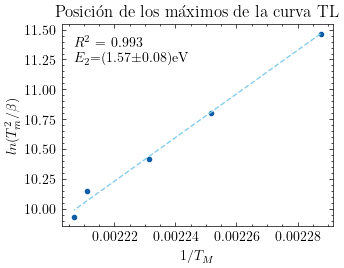

In [30]:
k = 0.0008617333262
k = 8.617333262E-5
tes = np.array([164,171,175,179.1,180])+273.15
plt.plot(1/(tes), np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes,np.log(tes**2/betas),1)
plt.plot(1/tes, slope * 1/tes + intercept,'--', color='skyblue', label=f'$E_2$={np.round(k*slope,2)} eV')
plt.legend()
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')
plt.show()

# Gráfica
plt.plot(1/tes, np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes, np.log(tes**2/betas), 1)
plt.plot(1/tes, slope * 1/tes + intercept, '--', color='skyblue')

# Coeficiente de determinación (R^2)
residuals = np.log(tes**2/betas) - (slope * 1/tes + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(tes**2/betas) - np.mean(np.log(tes**2/betas)))**2)
r_squared = 1 - (ss_res / ss_tot)

# Agregar R^2 a la leyenda
plt.legend(title=f'$R^2$ = {np.round(r_squared, 3)}\n $E_2$=({np.round(k*slope,2)}$\pm$0.08)eV')

# Configuración de ejes y título
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')

# Mostrar gráfica
plt.show()

In [28]:
# Datos
x = 1/tes
y = np.log(tes**2/betas)

# Cálculo de la pendiente y la intersección
slope, intercept = np.polyfit(x, y, 1)

# Cálculo del error en la pendiente
residuals = y - (slope * x + intercept)
ss_res = np.sum(residuals**2)
ss_x = np.sum((x - np.mean(x))**2)
std_error = np.sqrt(ss_res / (len(x) - 2))
error_pendiente = std_error / np.sqrt(ss_x)

print("Error en la pendiente:", error_pendiente)
print(slope*k, k*error_pendiente)

Error en la pendiente: 885.1657415276757
1.573943926021431 0.07627768186849335


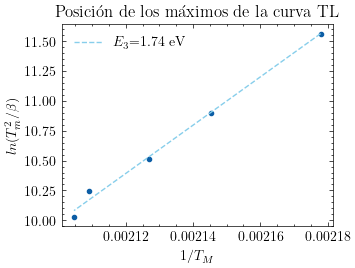

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


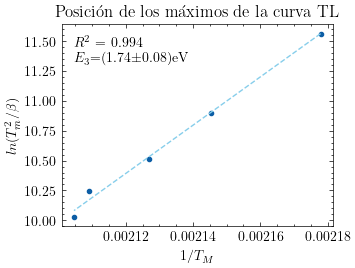

In [32]:
k = 0.0008617333262
k = 8.617333262E-5
tes = np.array([186,193,197,201,202])+273.15
plt.plot(1/(tes), np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes,np.log(tes**2/betas),1)
plt.plot(1/tes, slope * 1/tes + intercept,'--', color='skyblue', label=f'$E_3$={np.round(k*slope,2)} eV')
plt.legend()
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')
plt.show()

# Gráfica
plt.plot(1/tes, np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes, np.log(tes**2/betas), 1)
plt.plot(1/tes, slope * 1/tes + intercept, '--', color='skyblue')

# Coeficiente de determinación (R^2)
residuals = np.log(tes**2/betas) - (slope * 1/tes + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(tes**2/betas) - np.mean(np.log(tes**2/betas)))**2)
r_squared = 1 - (ss_res / ss_tot)

# Agregar R^2 a la leyenda
plt.legend(title=f'$R^2$ = {np.round(r_squared, 3)}\n $E_3$=({np.round(k*slope,2)}$\pm$0.08)eV')

# Configuración de ejes y título
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')

# Mostrar gráfica
plt.show()

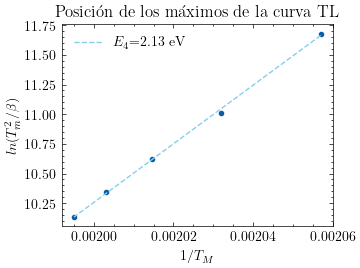

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


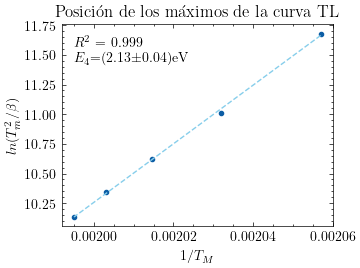

In [35]:
k = 0.0008617333262
k = 8.617333262E-5
tes = np.array([213,219,223.2,226.1,228.1])+273.15
plt.plot(1/(tes), np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes,np.log(tes**2/betas),1)
plt.plot(1/tes, slope * 1/tes + intercept,'--', color='skyblue', label=f'$E_4$={np.round(k*slope,2)} eV')
plt.legend()
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')
plt.show()

# Gráfica
plt.plot(1/tes, np.log(tes**2/betas), '.')
slope, intercept = np.polyfit(1/tes, np.log(tes**2/betas), 1)
plt.plot(1/tes, slope * 1/tes + intercept, '--', color='skyblue')

# Coeficiente de determinación (R^2)
residuals = np.log(tes**2/betas) - (slope * 1/tes + intercept)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(tes**2/betas) - np.mean(np.log(tes**2/betas)))**2)
r_squared = 1 - (ss_res / ss_tot)

# Agregar R^2 a la leyenda
plt.legend(title=f'$R^2$ = {np.round(r_squared, 3)}\n $E_4$=({np.round(k*slope,2)}$\pm$0.04)eV')

# Configuración de ejes y título
plt.xlabel('$1/T_M$')
plt.ylabel('$ln(T^2_m/\\beta)$')
plt.title('Posición de los máximos de la curva TL')

# Mostrar gráfica
plt.show()

In [34]:
# Datos
x = 1/tes
y = np.log(tes**2/betas)

# Cálculo de la pendiente y la intersección
slope, intercept = np.polyfit(x, y, 1)

# Cálculo del error en la pendiente
residuals = y - (slope * x + intercept)
ss_res = np.sum(residuals**2)
ss_x = np.sum((x - np.mean(x))**2)
std_error = np.sqrt(ss_res / (len(x) - 2))
error_pendiente = std_error / np.sqrt(ss_x)

print("Error en la pendiente:", error_pendiente)
print(slope*k, k*error_pendiente)

Error en la pendiente: 470.4422725217789
2.1267447192039333 0.040539578428527935


# Con distintos tiempos de irradiación:

In [279]:
print(nn)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [289]:
from scipy.integrate import solve_ivp
# Vamos a simular para 5 valores de beta:
tiempos = [1,10,20,30,40,50]  # Lista de valores de beta
CC = xr[-1]
# Vectores para almacenar los resultados
condiciones = []

for tm in tiempos:
    # Código para la resolución del sistema para cada valor de beta
    # ... (resto de tu código aquí) ...
    solcal = solve_ivp(fun=TLINE, t_span=(0, mt), y0=nn, method='RK45',
                       rtol=0.01, atol=0.0001, vectorized=False)

    x = solcal.y

    solrel = solve_ivp(fun=TLRNE, t_span=(0,10), y0=x[:,-1], method='RK45',
                        rtol=0.01, atol=0.001, vectoriced=False)

    # Guardar los resultados en los vectores correspondientes
    xr = solrel.y
    condiciones.append(xr[:,-1])
# Convertir los resultados en arrays numpy si es necesario
print(condiciones)
print('\u0007')

[array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]

In [299]:
print(condiciones)

[array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]), array([1.87535403e+08, 5.28116057e+03, 3.61078905e+03, 2.71466085e+03,
       2.71466085e+03, 7.87335543e+03, 9.97766122e+05, 0.00000000e+00,
       1.86559832e+08]

In [293]:
condicionesdf = pd.DataFrame(condiciones)
condicionesdf.to_csv('diferentesirradiaciones.csv')

In [368]:
print(condiciones[0])
print(len(condiciones))

a = condiciones[0]

[1.87535403e+08 5.28116057e+03 3.61078905e+03 2.71466085e+03
 2.71466085e+03 7.87335543e+03 9.97766122e+05 0.00000000e+00
 1.86559832e+08]
6


Calentamiento finalizado
200
Calentamiento finalizado
200
Calentamiento finalizado
200
Calentamiento finalizado
200
Calentamiento finalizado
200
Calentamiento finalizado
200


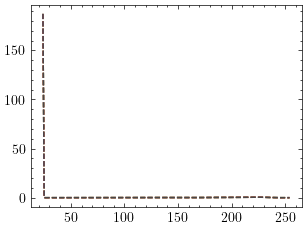




In [442]:
from scipy.integrate import solve_ivp
# Vamos a simular para 5 valores de beta:

# Vectores para almacenar los resultados
X1 = []
X10 = []
X20 = []
X30 = []
X40 = []
X50 = []

for i in range(len(condiciones)):
    # calentamiento


    beta = 10
    # aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
    mt = ((230+273.15)-Tamb)/beta

    solcal = integ.RK45(fun=TLE, t0=0, y0=condiciones[i], t_bound=mt, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)
    tc = []
    xc = []  # Iniziamos la variable que
    TT = []

    for j in range(100):
        for i in range(3000):
            # get solution step state
            if solcal.status == 'finished':
                break
            solcal.step()
            tc.append(solcal.t)
            TT.append(solcal.t*beta+Tamb-273.15)
            xc.append(solcal.y)
            # break loop after modeling is finished
            if solcal.status == 'finished':
                break
    xtemp = np.array(xc)
    ttemp = np.array(tc)
    xg, tg = g200(xtemp, TT)
    # Representamos la concentración en las trampas en la relajación
    temp, tlc, ti200 = tl200(xtemp.T, tc, beta)
    plt.plot(temp, tlc,'--' ,label=r'$\beta$='+str(b))
    
    print('Calentamiento finalizado')
    if i == 0:
        X1=xg
        T1 = tg
        print(len(X1))
    elif i == 1:
        X10=xg
        T10=tg
    elif i == 2:
        X20=xg
        T20 = xg
    elif i == 3:
        X30=xg
    elif i == 4:
        X40=xg
        T30=tg
    elif i == 5:
        T50=tg
        X50=xg

# Convertir los resultados en arrays numpy si es necesario
X1 = np.array(X1)
X10 = np.array(X10)
X20 = np.array(X20)
X30 = np.array(X30)
X40 = np.array(X40)
X50 = np.array(X50)
plt.show()
print('\u0007')

In [395]:
TTTT= np.linspace(0,230,200)

In [441]:
print(X10)
print(X10[:,0])

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

hola
0
[[1.87507102e+08 1.20524831e+04 8.15910210e+03 ... 9.97766122e+05
  0.00000000e+00 1.86559832e+08]
 [2.26521674e+00 4.48745420e+07 3.01423975e+07 ... 1.21261908e+06
  0.00000000e+00 1.86345727e+08]
 [2.23056768e+00 4.48748185e+07 3.01425832e+07 ... 1.42758579e+06
  0.00000000e+00 1.86131916e+08]
 ...
 [7.44215120e+00 9.94529064e+00 1.85791603e+01 ... 3.82947029e+07
  0.00000000e+00 1.49469004e+08]
 [6.57626960e+00 9.94529064e+00 1.51092229e+01 ... 3.84607342e+07
  0.00000000e+00 1.49304128e+08]
 [6.25251268e+00 9.94529064e+00 1.34458862e+01 ... 3.86265538e+07
  0.00000000e+00 1.49139464e+08]]
187507101.5317779
0
hola
1
[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

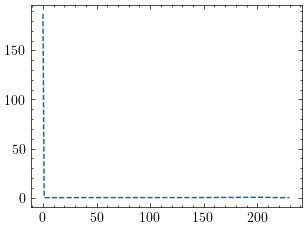

In [439]:
for i, X in enumerate([X1, X10, X20, X30, X40,X50]):
    xg = X
    print('hola')
    print(i)
    print(X)
    print(xg[i,0])
    print(i)
    tlc = np.zeros(200)
    tlc = A_R*xg[:,0]*xg[:,-3] /b
    plt.plot(TTTT, tlc,'--' ,label=r'$\beta$='+str(b))


plt.legend()

plt.title(r'$I_{tl}$')
plt.xlabel('canal')
plt.show()

# Sin creación de trampas

In [103]:
# Irradiación y relajación:
tmax = 20
tmaxr = 20
pasos = 100
# tmax=20                 #tiempo de irradiación
solirad = integ.RK45(fun=TLI, t0=0, y0=nn, t_bound=tmax, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)

NN = N
ti = []
xi = []  # Iniziamos la variable que

for i in range(100):

    for i in range(1000):
        # get solution step state
        if solirad.status == 'finished':
            break
        solirad.step()
        ti.append(solirad.t)
        xi.append(solirad.y)
        # break loop after modeling is finished
        if solirad.status == 'finished':
            break
    xtemp, ttemp = g200(np.array(xi), ti)
print('Irradiación finalizada')

solrel = integ.RK45(fun=TLR, t0=0, y0=xi[-1], t_bound=tmaxr, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tr = []
xr = []  # Iniziamos la variable que

for i in range(pasos):
    for i in range(1000):
        if solrel.status == 'finished':
            break
        # get solution step state
        solrel.step()
        tr.append(solrel.t)
        xr.append(solrel.y)
        # break loop after modeling is finished
        if solrel.status == 'finished':
            break
    xtempr = np.array(xr)

    # Representamos la concentración en las trampas en la relajación
xi = np.array(xi)
xr = np.array(xr)

print('finalizado')

Irradiación finalizada
finalizado


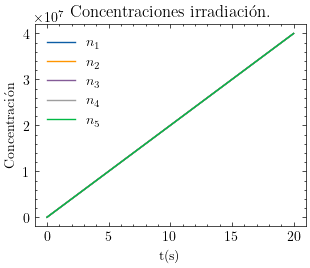

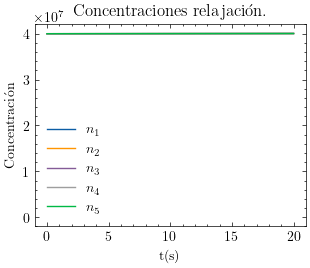

In [104]:
# Representamos la concentración en las trampas en la irradiación
for i in range(1, len(nn)-3):
    plt.plot(ti, xi[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones irradiación.')
    plt.xlabel('t(s)')
    plt.ylabel('Concentración')
plt.show()


for i in range(1, len(nn)-3):
    plt.plot(tr, xr[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones relajación.')
    plt.xlabel('t(s)')
    plt.ylabel('Concentración')
plt.show()

In [105]:
# calentamiento
for i in range(len(N)):
    # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
    NN[i] =N[i]

CC = xr[-1]

beta = 10
# aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
mt = ((230+273.15)-Tamb)/beta

solcal = integ.RK45(fun=TLE, t0=0, y0=CC, t_bound=mt, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tc = []
xc = []  # Iniziamos la variable que
TT = []

for j in range(100):
    for i in range(3000):
        # get solution step state
        if solcal.status == 'finished':
            break
        solcal.step()
        tc.append(solcal.t)
        TT.append(solcal.t*beta+Tamb-273.15)
        xc.append(solcal.y)
        # break loop after modeling is finished
        if solcal.status == 'finished':
            break
xtemp = np.array(xc)
ttemp = np.array(tc)
xg, tg = g200(xtemp, TT)
# Representamos la concentración en las trampas en la relajación
tempn, tlcn, ti200n = tl200(xtemp.T, tc, beta)
print('Calentamiento finalizado')

Calentamiento finalizado


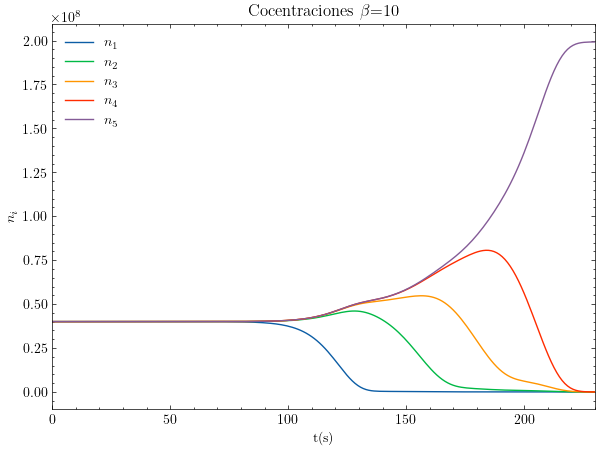

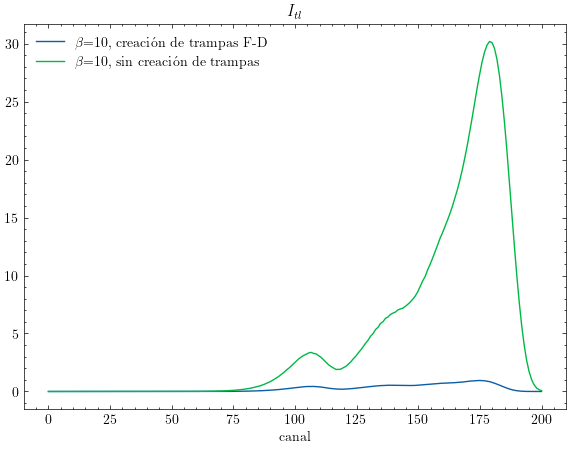

In [106]:
fig = plt.figure(figsize=(7,5))
for i in range(1, len(nn)-3):
    plt.plot(tg, xg[:, i], label=f'$n_{i}$')
plt.legend()
plt.xlim(0, 230)
plt.title(r'Cocentraciones $\beta$=' + str(beta))
plt.xlabel('t(s)')
plt.ylabel('$n_i$')
plt.show()
plt.figure(figsize=(7,5))
# plt.plot(ttemp/mt*200,tlc)
plt.plot(ti200/mt*200, tlc,'-' ,label=r'$\beta$='+str(beta)+', creación de trampas F-D')
plt.plot(ti200n/mt*200, tlcn,'-' ,label=r'$\beta$='+str(beta)+', sin creación de trampas')
plt.legend()

plt.title(r'$I_{tl}$')
plt.xlabel('canal')
plt.show()

# Solo creación de trampas:

In [107]:
# Irradiación y relajación:
tmax = 20
tmaxr = 20
pasos = 100
# tmax=20                 #tiempo de irradiación
solirad = integ.RK45(fun=TLIN, t0=0, y0=nn, t_bound=tmax, max_step=np.inf,
                        rtol=0.01, atol=0.01, vectorized=False, first_step=None)

for i in range(len(N)):
    # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
    NN[i] = Ng(tmax, i)
ti = []
xi = []  # Iniziamos la variable que

for i in range(100):

    for i in range(1000):
        # get solution step state
        if solirad.status == 'finished':
            break
        solirad.step()
        ti.append(solirad.t)
        xi.append(solirad.y)
        # break loop after modeling is finished
        if solirad.status == 'finished':
            break
    xtemp, ttemp = g200(np.array(xi), ti)
print('Irradiación finalizada')

solrel = integ.RK45(fun=TLR, t0=0, y0=xi[-1], t_bound=tmaxr, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tr = []
xr = []  # Iniziamos la variable que

for i in range(pasos):
    for i in range(1000):
        if solrel.status == 'finished':
            break
        # get solution step state
        solrel.step()
        tr.append(solrel.t)
        xr.append(solrel.y)
        # break loop after modeling is finished
        if solrel.status == 'finished':
            break
    xtempr = np.array(xr)

    # Representamos la concentración en las trampas en la relajación
xi = np.array(xi)
xr = np.array(xr)

print('finalizado')

Irradiación finalizada
finalizado


In [109]:
# calentamiento
for i in range(len(N)):
    # aquí estamos actualizando el numero de trampas que hay después de crearse para que lo use el resto de funciones
    NN[i] = Ng(tmax,i)

CC = xr[-1]

beta = 10
# aquí definimos la temperatura máxima que queremos alcanzar en grados kelvin
mt = ((230+273.15)-Tamb)/beta

solcal = integ.RK45(fun=TLE, t0=0, y0=CC, t_bound=mt, max_step=np.inf,
                    rtol=0.01, atol=0.01, vectorized=False, first_step=None)
tc = []
xc = []  # Iniziamos la variable que
TT = []

for j in range(100):
    for i in range(3000):
        # get solution step state
        if solcal.status == 'finished':
            break
        solcal.step()
        tc.append(solcal.t)
        TT.append(solcal.t*beta+Tamb-273.15)
        xc.append(solcal.y)
        # break loop after modeling is finished
        if solcal.status == 'finished':
            break
xtemp = np.array(xc)
ttemp = np.array(tc)
xg, tg = g200(xtemp, TT)
# Representamos la concentración en las trampas en la relajación
tempnf, tlcnf, ti200nf = tl200(xtemp.T, tc, beta)
print('Calentamiento finalizado')

Calentamiento finalizado


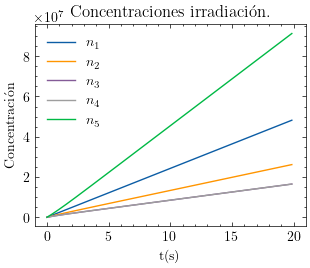

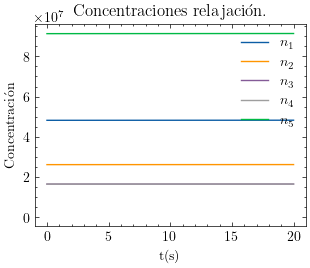

In [110]:
# Representamos la concentración en las trampas en la irradiación
for i in range(1, len(nn)-3):
    plt.plot(ti, xi[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones irradiación.')
    plt.xlabel('t(s)')
    plt.ylabel('Concentración')
plt.show()


for i in range(1, len(nn)-3):
    plt.plot(tr, xr[:, i], label=f'$n_{i}$')
    plt.plot(tmax, 0)
    plt.legend()
    plt.title(
        'Concentraciones relajación.')
    plt.xlabel('t(s)')
    plt.ylabel('Concentración')
plt.show()

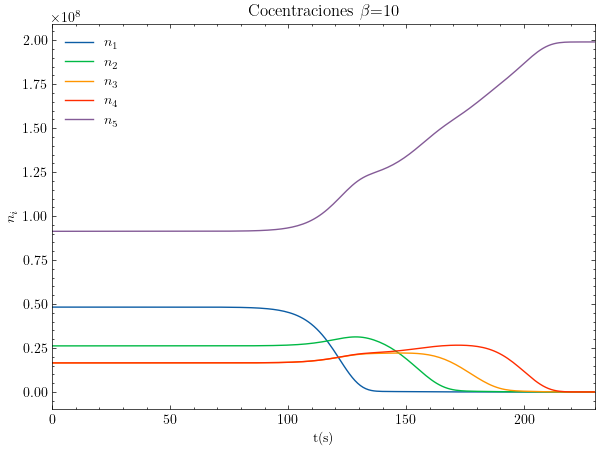

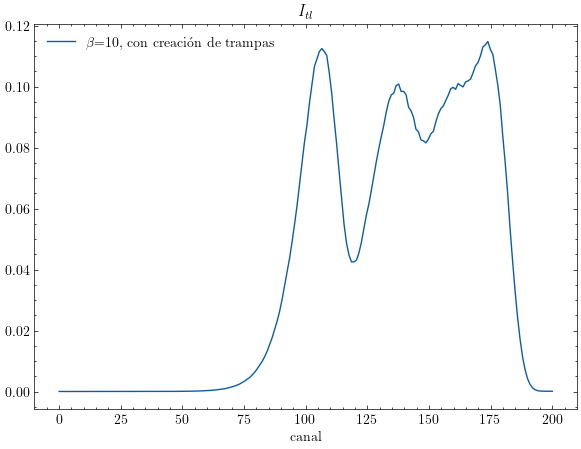

In [113]:
fig = plt.figure(figsize=(7,5))
for i in range(1, len(nn)-3):
    plt.plot(tg, xg[:, i], label=f'$n_{i}$')
plt.legend()
plt.xlim(0, 230)
plt.title(r'Cocentraciones $\beta$=' + str(beta))
plt.xlabel('t(s)')
plt.ylabel('$n_i$')
plt.show()
plt.figure(figsize=(7,5))
# plt.plot(ttemp/mt*200,tlc)
#plt.plot(ti200/mt*200, tlc,'-' ,label=r'$\beta$='+str(beta)+', creación de trampas y F-D')
# plt.plot(ti200n/mt*200, tlcn,'-' ,label=r'$\beta$='+str(beta)+', sin creación de trampas')
plt.plot(ti200nf/mt*200, tlcnf,'-' ,label=r'$\beta$='+str(beta)+', con creación de trampas')
plt.legend()

plt.title(r'$I_{tl}$')
plt.xlabel('canal')
plt.show()